In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import f_classif, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load Data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print(f"Original Dataset Shape: {X.shape}")
print(f"Original Features: {X.columns.tolist()}")
print("="*60)


Original Dataset Shape: (569, 30)
Original Features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


In [10]:
def drop_redundant_features(X, threshold=0.9, method='pearson'):
    """Remove highly correlated features"""
    corr_matrix = X.corr(method=method)
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    dropped_features = [
        col for col in upper_triangle.columns
        if any(abs(upper_triangle[col]) > threshold)  # Added abs() for negative correlations
    ]
      
    print(f"\n{method.upper()} Correlation (threshold={threshold}):")
    print(f"Features to drop: {dropped_features}")
    print(f"Number of features dropped: {len(dropped_features)}")
    
    X_reduced = X.drop(columns=dropped_features)
    return X_reduced, dropped_features


PEARSON Correlation (threshold=0.9):
Features to drop: ['mean perimeter', 'mean area', 'mean concave points', 'perimeter error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst concave points']
Number of features dropped: 10
Shape after Pearson: (569, 20)


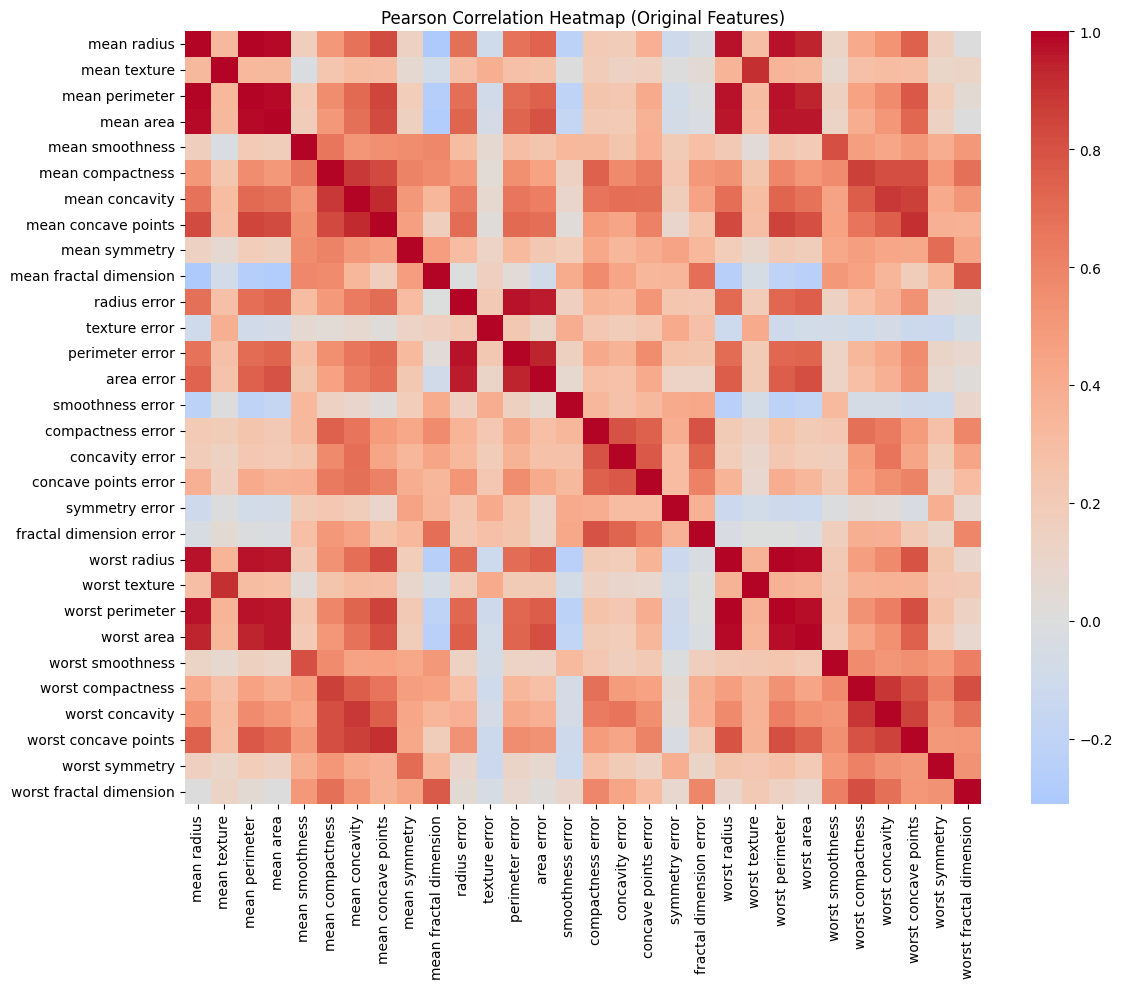

In [11]:
# Apply Pearson correlation
X_pearson, dropped_pearson = drop_redundant_features(X, 0.9, 'pearson')
print(f"Shape after Pearson: {X_pearson.shape}")

# Visualize correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(method='pearson'), cmap='coolwarm', center=0)
plt.title('Pearson Correlation Heatmap (Original Features)')
plt.tight_layout()
plt.show()


In [12]:

# Apply Spearman correlation on reduced set
X_spearman, dropped_spearman = drop_redundant_features(X_pearson, 0.9, 'spearman')
print(f"Shape after Spearman: {X_spearman.shape}")


SPEARMAN Correlation (threshold=0.9):
Features to drop: ['worst compactness', 'worst concavity']
Number of features dropped: 2
Shape after Spearman: (569, 18)


In [13]:

# ============================================================
# 2. ANOVA F-TEST (Numerical Features vs Categorical Target)
# ============================================================

def remove_low_anova_features(X, y, threshold=5):
    """Remove features with low ANOVA F-scores"""
    anova_scores, p_values = f_classif(X, y)
    
    anova_df = pd.DataFrame({
        'Feature': X.columns,
        'ANOVA Score': anova_scores,
        'P-Value': p_values
    }).sort_values(by='ANOVA Score', ascending=False)
    
    print("\nANOVA F-Test Results:")
    print(anova_df.to_string())
    
    mask = anova_scores >= threshold
    X_anova = X.loc[:, mask]
    
    removed = X.columns[~mask].tolist()
    print(f"\nFeatures removed (ANOVA score < {threshold}): {removed}")
    print(f"Shape after ANOVA: {X_anova.shape}")
    
    return X_anova, anova_df

In [14]:

X_anova, anova_df = remove_low_anova_features(X_spearman, y, threshold=5)

# ============================================================
# 3. CHI-SQUARE TEST (Synthetic Categorical Feature)
# ============================================================

# Add synthetic categorical feature
X_final = X_anova.copy()
X_final['tumor_size'] = pd.cut(
    X_final['mean radius'],
    bins=[0, 12, 18, np.inf],
    labels=['small', 'medium', 'large']
)



ANOVA F-Test Results:
                    Feature  ANOVA Score       P-Value
0               mean radius   646.981021  8.465941e-96
4            mean concavity   533.793126  9.966556e-84
3          mean compactness   313.233079  3.938263e-56
7              radius error   268.840327  9.738949e-50
15         worst smoothness   122.472880  6.575144e-26
16           worst symmetry   118.860232  2.951121e-25
1              mean texture   118.096059  4.058636e-25
12     concave points error   113.262760  3.072309e-24
2           mean smoothness    83.651123  1.051850e-18
5             mean symmetry    69.527444  5.733384e-16
17  worst fractal dimension    66.443961  2.316432e-15
10        compactness error    53.247339  9.975995e-13
11          concavity error    39.014482  8.260176e-10
14  fractal dimension error     3.468275  6.307355e-02
9          smoothness error     2.557968  1.102966e-01
6    mean fractal dimension     0.093459  7.599368e-01
8             texture error     0.039095  

In [15]:

# Encode categorical feature
le = LabelEncoder()
X_final['tumor_size_encoded'] = le.fit_transform(X_final['tumor_size'])


In [18]:

# Chi-Square Test
X_categorical = X_final[['tumor_size_encoded']]
chi2_scores, p_values = chi2(X_categorical, y)

chi2_df = pd.DataFrame({
    'Feature': X_categorical.columns,
    'Chi2 Score': chi2_scores,
    'P-Value': p_values
})


print("\nChi-Square Test Results:")
print(chi2_df)

# Drop categorical columns for final numerical features
X_final = X_final.drop(columns=['tumor_size', 'tumor_size_encoded'])

print(f"\nFinal reduced features ({X_final.shape[1]}): {X_final.columns.tolist()}")




Chi-Square Test Results:
              Feature  Chi2 Score       P-Value
0  tumor_size_encoded   87.965759  6.659741e-21

Final reduced features (13): ['mean radius', 'mean texture', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean symmetry', 'radius error', 'compactness error', 'concavity error', 'concave points error', 'worst smoothness', 'worst symmetry', 'worst fractal dimension']


In [19]:

# ============================================================
# 4. KNN COMPARISON: 30 FEATURES vs REDUCED FEATURES
# ============================================================

def evaluate_knn(X, y, n_neighbors=5, description=""):
    """Evaluate KNN with cross-validation and test set"""
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Cross-validation
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    
    # Fit and predict
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n{'='*60}")
    print(f"KNN EVALUATION: {description}")
    print(f"{'='*60}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Number of neighbors (k): {n_neighbors}")
    print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print(f"Test Set Accuracy: {test_accuracy:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))
    
    return {
        'description': description,
        'n_features': X.shape[1],
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': test_accuracy,
        'y_test': y_test,
        'y_pred': y_pred
    }

In [20]:

# Evaluate on Original 30 Features
results_30 = evaluate_knn(X, y, n_neighbors=5, description="Original 30 Features")

# Evaluate on Reduced Features
results_reduced = evaluate_knn(X_final, y, n_neighbors=5, 
                                description=f"Reduced {X_final.shape[1]} Features")



KNN EVALUATION: Original 30 Features
Number of features: 30
Number of neighbors (k): 5

Cross-Validation Accuracy: 0.9670 (+/- 0.0417)
Test Set Accuracy: 0.9649

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.97      0.93      0.95        42
      Benign       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114


KNN EVALUATION: Reduced 13 Features
Number of features: 13
Number of neighbors (k): 5

Cross-Validation Accuracy: 0.9516 (+/- 0.0599)
Test Set Accuracy: 0.9386

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.93      0.90      0.92        42
      Benign       0.95      0.96      0.95        72

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0


COMPARISON SUMMARY
            Metric Original (30 Features) Reduced Features
Number of Features                     30               13
CV Accuracy (Mean)                 0.9670           0.9516
 CV Accuracy (Std)                 0.0209           0.0300
     Test Accuracy                 0.9649           0.9386


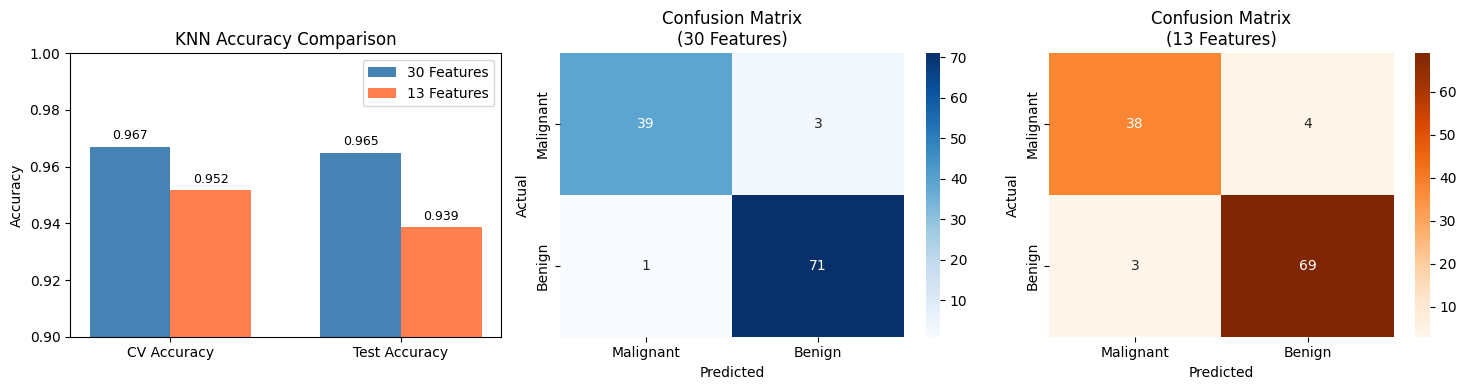


FINAL SELECTED FEATURES

Original Features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

Selected Features (13): ['mean radius', 'mean texture', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean symmetry', 'radius error', 'compactness error', 'concavity error', 'concave points error', 'worst smoothness', 'worst symmetry', 'worst fractal dimension']

Removed Features (17): {'worst concavity', 'area error', 'perimeter error', 'worst area', 'worst radiu

In [21]:

# ============================================================
# 5. COMPARISON VISUALIZATION
# ============================================================

# Comparison Summary
comparison_df = pd.DataFrame({
    'Metric': ['Number of Features', 'CV Accuracy (Mean)', 'CV Accuracy (Std)', 'Test Accuracy'],
    'Original (30 Features)': [30, f"{results_30['cv_mean']:.4f}", 
                                f"{results_30['cv_std']:.4f}", 
                                f"{results_30['test_accuracy']:.4f}"],
    'Reduced Features': [results_reduced['n_features'], 
                         f"{results_reduced['cv_mean']:.4f}",
                         f"{results_reduced['cv_std']:.4f}", 
                         f"{results_reduced['test_accuracy']:.4f}"]
})

print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Bar plot - Accuracy Comparison
ax1 = axes[0]
metrics = ['CV Accuracy', 'Test Accuracy']
original_scores = [results_30['cv_mean'], results_30['test_accuracy']]
reduced_scores = [results_reduced['cv_mean'], results_reduced['test_accuracy']]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, original_scores, width, label='30 Features', color='steelblue')
bars2 = ax1.bar(x + width/2, reduced_scores, width, label=f'{results_reduced["n_features"]} Features', color='coral')

ax1.set_ylabel('Accuracy')
ax1.set_title('KNN Accuracy Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim(0.9, 1.0)

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

# Confusion Matrix - Original
ax2 = axes[1]
cm1 = confusion_matrix(results_30['y_test'], results_30['y_pred'])
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
ax2.set_title('Confusion Matrix\n(30 Features)')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

# Confusion Matrix - Reduced
ax3 = axes[2]
cm2 = confusion_matrix(results_reduced['y_test'], results_reduced['y_pred'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Oranges', ax=ax3,
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
ax3.set_title(f'Confusion Matrix\n({results_reduced["n_features"]} Features)')
ax3.set_ylabel('Actual')
ax3.set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# ============================================================
# 6. FEATURE IMPORTANCE ANALYSIS
# ============================================================

print("\n" + "="*60)
print("FINAL SELECTED FEATURES")
print("="*60)
print(f"\nOriginal Features: {list(X.columns)}")
print(f"\nSelected Features ({X_final.shape[1]}): {list(X_final.columns)}")
print(f"\nRemoved Features ({30 - X_final.shape[1]}): {set(X.columns) - set(X_final.columns)}")

